# Importing libraries and loading files

In [39]:
# Importing libraries and loading data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

customer_data = pd.read_csv("clv_transactions.csv")

# Converting object to datetime
customer_data["TransactionDate"] = pd.to_datetime(customer_data["TransactionDate"], format= "%m/%d/%Y")

# Step 1: Understanding the data

In [40]:
customer_data.head(5)

,TransactionID,TransactionDate,CustomerID,Amount
0,1,2012-09-04,1,20.26
1,2,2012-05-15,2,10.87
2,3,2014-05-23,2,2.21
3,4,2014-10-24,2,10.48
4,5,2012-10-13,2,3.94


In [41]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4186 entries, 0 to 4185
Data columns (total 4 columns):
TransactionID      4186 non-null int64
TransactionDate    4186 non-null datetime64[ns]
CustomerID         4186 non-null int64
Amount             4186 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 130.9 KB


## Checking for missing values

In [42]:
customer_data.isna().sum()

TransactionID      0
TransactionDate    0
CustomerID         0
Amount             0
dtype: int64

There seem to be no missing values in the data set

## Checking the range of dates

In [43]:

customer_data["TransactionDate"].agg([min, max])

min   2010-01-04
max   2015-12-31
Name: TransactionDate, dtype: datetime64[ns]

The oldest date is 1/4/2010 and the last date of the transactions is 12/31/2015

## Number of unique customers

In [44]:
customer_data["CustomerID"].nunique()

1000

There are 1000 unique customer Ids in the data

## Descriptive stats for amount field

In [88]:
round(customer_data[["Amount"]].describe().transpose(), 2)

,count,mean,std,min,25%,50%,75%,max
Amount,4186.0,9.03,38.72,-1.0,3.31,6.88,11.69,2033.0


In [90]:
round(customer_data["Amount"].var(), 2)

1499.54

- Mean = 9.03
- Median = 6.88
- Min = -1
- Max = 2033
- Std dev = 38.72
- Variance = 1499.54


## Transaction amounts over time

In [ ]:
customer_data_wo_outliers

(733863.0, 736255.1603494624)

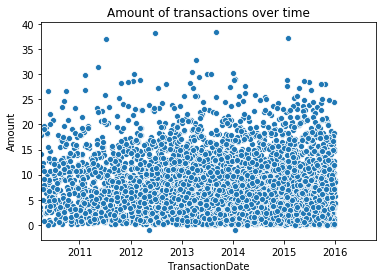

In [46]:
# Considering amounts without high values for better visualization
customer_data_wo_outliers = customer_data.loc[customer_data["Amount"]<500, ];

g = sns.scatterplot(data=customer_data_wo_outliers, x = "TransactionDate", y = "Amount");

g.set(title = "Amount of transactions over time")

g.set_xlim(pd.datetime(2010, 4, 1))

There seems to be a slight increase in the spending but there is no obvious pattern in it

# Step 2: Checking for outliers

## Checking the distribution of the amount column

[]

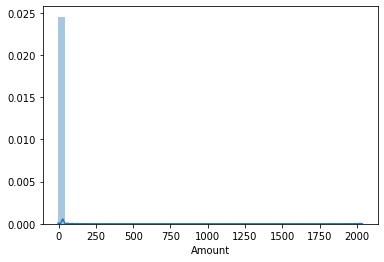

In [91]:
sns.distplot(customer_data["Amount"])
plt.plot()

The data has a very long tail. This means that there are outliers in the data. 

In [49]:
round(customer_data[["Amount"]].describe().transpose(), 2)

,count,mean,std,min,25%,50%,75%,max
Amount,4186.0,9.03,38.72,-1.0,3.31,6.88,11.69,2033.0


The max value is 2033 which is very high as compared to the mean calue for 9.03 and the median of 6.88.
Also, the mean>median because of which data is right skewed 

## Removing outliers using +-3 Std Deviations

In [99]:
# Extracting std and mean value to use for removing outliers
standard_deviation = customer_data["Amount"].std(axis = 0)
mean_value = customer_data["Amount"].mean()

In [65]:
customer_data_wo_outliers = customer_data.loc[(customer_data["Amount"]< (mean_value + 3*standard_deviation)) & (customer_data["Amount"] > (mean_value - 3*standard_deviation)), ]

Removing data points that are more than 3 standard deviations away from the mean


# Step 3: Determining origin year of customers

In [101]:
# Extracting relevant columns and taking first transaction for every customer
temp = customer_data_wo_outliers[["CustomerID", "TransactionDate"]].groupby("CustomerID").min().reset_index()

# Extracting Year from date
temp["Origin Year"] = temp["TransactionDate"].apply(lambda x: x.year)

temp = temp[["CustomerID", "Origin Year"]]

customer_data_origin_year = pd.merge(customer_data_wo_outliers, temp, how = "left", on = "CustomerID")

customer_data_origin_year

,TransactionID,TransactionDate,CustomerID,Amount,Origin Year
0,1,2012-09-04,1,20.26,2012
1,2,2012-05-15,2,10.87,2012
2,3,2014-05-23,2,2.21,2012
3,4,2014-10-24,2,10.48,2012
4,5,2012-10-13,2,3.94,2012
...,...,...,...,...,...
4178,4182,2013-06-23,1000,3.86,2010
4179,4183,2011-08-07,1000,4.00,2010
4180,4184,2012-10-07,1000,18.37,2010
4181,4185,2014-01-09,1000,3.45,2010


# Step 4: Calculating cumulative transaction amounts

Adding transaction year to each row

In [107]:
customer_data_origin_year["Transaction Year"] = customer_data_origin_year["TransactionDate"].apply(lambda x: x.year)

# For each transaction, calculating the time since the first transaction for the customer
customer_data_origin_year["Months since first transaction"]  = (customer_data_origin_year["Transaction Year"] - customer_data_origin_year["Origin Year"] + 1)*12

# Getting the cumulative sum over time
intermediate = customer_data_origin_year[["Origin Year", "Months since first transaction", "Amount"]].sort_values(by = ["Origin Year", "Months since first transaction"]).groupby(["Origin Year", "Months since first transaction"]).sum()
final1 = intermediate.groupby(level=[0]).cumsum().reset_index()

# Changing the column names to reflect the date ranges
convert = dict(zip([2010, 2011, 2012, 2013, 2014, 2015],['2010-01-01 - 2010-12-31','2011-01-01 - 2011-12-31','2012-01-01 - 2012-12-31','2013-01-01 - 2013-12-31','2014-01-01 - 2014-12-31','2015-01-01 - 2015-12-31']))
final1["Origin Year"] = final1["Origin Year"].astype("category")
final1["Origin Year"] = final1["Origin Year"].cat.rename_categories(convert)


In [103]:
final1.pivot_table(index='Origin Year', columns='Months since first transaction', values='Amount', fill_value = "")

Months since first transaction,12,24,36,48,60,72
Origin Year,,,,,,
2010-01-01 - 2010-12-31,2259.67,3614.78,5274.81,6632.37,7930.69,8964.49
2011-01-01 - 2011-12-31,2238.46,3756.9,5464.99,6702.11,7861.24,
2012-01-01 - 2012-12-31,2181.35,3874.69,5226.86,6501.85,,
2013-01-01 - 2013-12-31,2179.85,3608.81,5226.75,,,
2014-01-01 - 2014-12-31,1830.85,3262.05,,,,
2015-01-01 - 2015-12-31,1912.17,,,,,


# Step 5: Calculate new customers by origin year in each year 

In [104]:
# Extracting the transaction year
customer_data_origin_year["Transaction Year"] = customer_data_origin_year["TransactionDate"].apply(lambda x: x.year)

# Calculating the time since first transaction for every customer
customer_data_origin_year["Months since first transaction"]  = (customer_data_origin_year["Transaction Year"] - customer_data_origin_year["Origin Year"] + 1)*12

# Calculating the unique customers for each point in time
intermediate = customer_data_origin_year[["Origin Year", "Months since first transaction", "CustomerID"]].groupby(["Origin Year", "Months since first transaction"]).agg({"CustomerID": "nunique"}).reset_index()

temp = intermediate[["Origin Year", "CustomerID"]].groupby(["Origin Year"]).max().reset_index()

final2 = pd.merge(intermediate, temp, how="left", on = "Origin Year")

# Changing the column names to reflect the date ranges
convert = dict(zip([2010, 2011, 2012, 2013, 2014, 2015],['2010-01-01 - 2010-12-31','2011-01-01 - 2011-12-31','2012-01-01 - 2012-12-31','2013-01-01 - 2013-12-31','2014-01-01 - 2014-12-31','2015-01-01 - 2015-12-31']))
final2["Origin Year"] = final2["Origin Year"].astype("category")
final2["Origin Year"] = final2["Origin Year"].cat.rename_categories(convert)



In [105]:
round(final2.pivot_table(index='Origin Year', columns='Months since first transaction', values='CustomerID_y', fill_value = ""), 0)

Months since first transaction,12,24,36,48,60,72
Origin Year,,,,,,
2010-01-01 - 2010-12-31,172.0,172,172,172,172,172
2011-01-01 - 2011-12-31,170.0,170,170,170,170,
2012-01-01 - 2012-12-31,163.0,163,163,163,,
2013-01-01 - 2013-12-31,180.0,180,180,,,
2014-01-01 - 2014-12-31,155.0,155,,,,
2015-01-01 - 2015-12-31,160.0,,,,,


# Step 6: Finding the historic value

In [87]:
clv = pd.merge(final1, final2, how = "inner", on = ["Origin Year", "Months since first transaction"])

# Dividing the value by count of customers to get the average amount spent by the customer in each group
clv["Historic value"] = round(clv["Amount"]/ clv["CustomerID_y"],2)

clv.pivot_table(index='Origin Year', columns='Months since first transaction', values='Historic value', fill_value = "")


Months since first transaction,12,24,36,48,60,72
Origin Year,,,,,,
2010-01-01 - 2010-12-31,13.14,21.02,30.67,38.56,46.11,52.12
2011-01-01 - 2011-12-31,13.17,22.1,32.15,39.42,46.24,
2012-01-01 - 2012-12-31,13.38,23.77,32.07,39.89,,
2013-01-01 - 2013-12-31,12.11,20.05,29.04,,,
2014-01-01 - 2014-12-31,11.81,21.05,,,,
2015-01-01 - 2015-12-31,11.95,,,,,


[Text(0, 0.5, 'Historic CLV'),
 Text(0.5, 0, 'Age'),
 Text(0.5, 1.0, 'Customer Historic value over time')]

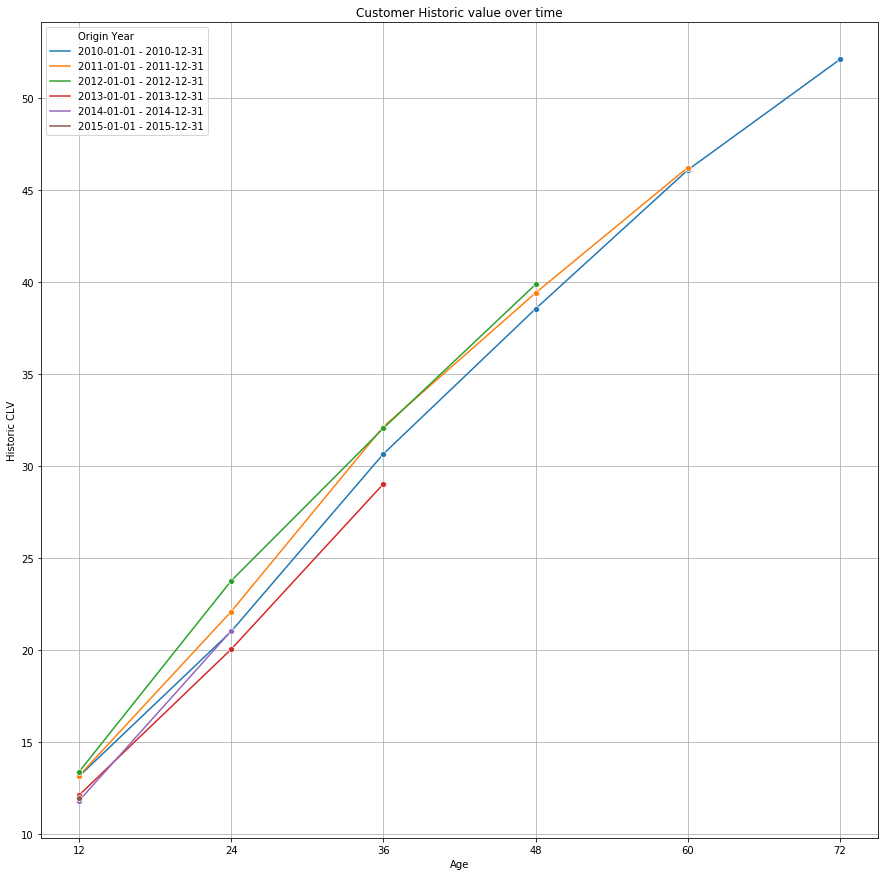

In [73]:
plt.figure(figsize = (15,15))
plt.grid()
clv['Months since first transaction'] = clv['Months since first transaction'].astype("str")

g = sns.lineplot(data= clv, x = 'Months since first transaction', y = "Historic value", hue = "Origin Year", marker = "o" );

g.set(title = "Customer Historic value over time", xlabel = "Age", ylabel = "Historic CLV")


In [106]:
# Calculating the average value for historic CLv for each group
ans3 = round(clv[["Historic value", "Months since first transaction"]].groupby("Months since first transaction").mean(), 2).reset_index()

ans3.columns = ["Age", "HistoricCLV"]

ans3.groupby("Age").mean()

,HistoricCLV
Age,
12,12.59
24,21.60
36,30.98
48,39.29
60,46.18
72,52.12


## How much have customers acquired in 2011 spent to date?

- The amount spent by the customers acquired in 2011 is \\$ 7861.24. 

- The historic CLV for the group is \\$ 46.24.This means that on average, each customer acquired in 2011 has spent \\$ 46.24 in the store. The number of such customers is 170.

## Do each group of customers exhibit similar or different patterns of spending? What’s the implication for the business?

- According to the graphs, the customer spend the same amount of money irrespective of the year they arrived in the system 
- The store might want to spend more on marketing to improve sales. The business is staying fairly constant over time in terms of the sales. 
- Therefore, the store should account for inflation and increase marketing to encourage customers to spend more.

